In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve
from scipy.signal import savgol_filter, find_peaks
from collections import defaultdict
import pickle

In [102]:
def nested_dict():
    return defaultdict(nested_dict)

In [103]:
def theta_equation(theta, x, y, l, d):
    added_distance = d / 2 * np.tan(theta)
    x_transf = x - added_distance
    r = l + added_distance

    return np.arccos(np.sqrt(r**2 - x_transf**2 - y**2) / r) - theta

In [113]:
import glob

filenames = glob.glob("../data/**/*.txt", recursive=True)

In [105]:
filenames = ['../data/d_10mm/l_100mm/d_10mm_l_100mm_80deg.txt']

In [121]:
data_map = nested_dict()

for filename in filenames:
    filename_no_path = filename.split("/")[-1]
    d = int(filename_no_path.split("_")[1][:-2])
    l = int(filename_no_path.split("_")[3][:-2])
    initial_angle = int(filename_no_path.split("_")[-1][:-7])

    df_file = pd.read_csv(filename, skiprows=1)
    df_file = df_file.drop('Unnamed: 3', axis=1)
    df_file['x'] = (df_file['x']) * 148 / 654
    df_file['y'] = (df_file['y']) * 148 / 654

    df_file['z'] = np.sqrt(np.abs((l + d)**2 - df_file['x']**2 - df_file['y']**2))

    df_file['phi'] = np.sign(df_file['y']) * np.arccos(df_file['x'] / np.sqrt(df_file['x']**2 + df_file['y']**2))

    theta = np.ndarray([len(df_file)])
    for i, row in df_file.iterrows():
        theta[i] = fsolve(theta_equation, x0=np.array([np.pi/4]), args=(row['x'], row['y'], l, d))

    df_file['theta'] = savgol_filter(theta, 10, 3)

    peaks, _ = find_peaks(-df_file['theta'], prominence=0)

    # Peaks with value smaller than 15 degrees(approx. 0.26 radians)
    peaks = peaks[df_file['theta'][peaks] < 0.26]

    peaks_beginning = peaks[::2]
    peaks_end = peaks[1::2]

    if len(peaks_beginning) > len(peaks_end):
        peaks_beginning = peaks_beginning[:-1]

    negative_parts_bounds = np.column_stack([peaks_beginning, peaks_end])

    for bound in negative_parts_bounds:
        df_file['theta'][bound[0]:bound[1]] = 0 - df_file['theta'][bound[0]:bound[1]]

    data_map[d][l][initial_angle] = df_file

with open('data.pickle', 'wb') as f:
    pickle.dump(data_map, f)

/tmp/ipykernel_238175/3531340381.py:6: RuntimeWarning: invalid value encountered in sqrt
  return np.arccos(np.sqrt(r**2 - x_transf**2 - y**2) / r) - theta
/home/robomaze/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_238175/3531340381.py:6: RuntimeWarning: invalid value encountered in sqrt
  return np.arccos(np.sqrt(r**2 - x_transf**2 - y**2) / r) - theta
/home/robomaze/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/robomaze/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten

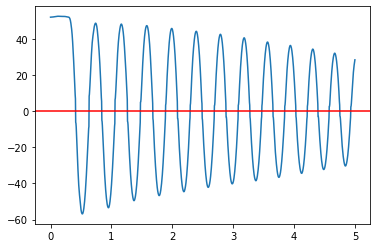

In [122]:
a = data_map[10][100][40]
plt.plot(a['t'][a['t'] < 5], a['theta'][a['t'] < 5] * 180 / np.pi)
plt.axhline(y = 0   , color = 'r', linestyle = '-')